In [1]:
#Importing our Packages: Analytics
import pandas as pd
import numpy as np

#Viz libaries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

#Data_libraries
import pymysql
import sqlalchemy


#Sklearn libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso

#Scoring libraries
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import r2_score

<AxesSubplot:>

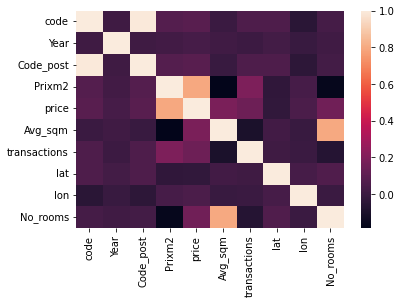

In [2]:
#Create String for data creation
#Some Basic descriptive Statistics over time for each commune
querystring = """
SELECT dwu.code_commune AS code,
dwu.type_local AS type,  
year(dwu.date_mutation) AS 'Year', 
dwu.nom_commune AS commune,
dwu.code_postal AS Code_post,
ROUND(AVG(dwu.valeur_fonciere/dwu.surface_reelle_bati),0) AS Prixm2,
ROUND(AVG(dwu.valeur_fonciere),0) AS price,
ROUND(AVG(dwu.surface_reelle_bati),0) AS Avg_sqm,
COUNT(dwu.id_mutation) AS transactions,
MAX(dwu.latitude) AS lat,
MAX(dwu.longitude) AS lon,
ROUND(AVG(dwu.nombre_pieces_principales),1) AS No_rooms
FROM data_working_update dwu
WHERE dwu.type_local IN('Appartement', 'Maison')
GROUP BY code_commune, dwu.code_postal,year(dwu.date_mutation), nom_commune, dwu.type_local;
"""

#Load Libraries and Create engine Connection

engine =sqlalchemy.create_engine(
        sqlalchemy.engine.url.URL.create(
        drivername="mysql+pymysql",
        username='Estimators',  # e.g. "my-database-user"
        password='Wagon',  # e.g. "my-database-password"
        host='34.77.88.127',  # e.g. "127.0.0.1"
        port=3306,  # e.g. 3306
        database='Housing_France',  # e.g. "my-database-name"
    ))

conn = engine.connect().execution_options(stream_results=True)    

def get_data(querystring,chunk):
    engine =sqlalchemy.create_engine(
    sqlalchemy.engine.url.URL.create(
    drivername="mysql+pymysql",
    username='Estimators',  #
    password='Wagon',  # e.g. "my-database-password"
    host='34.77.88.127',  # e.g. "127.0.0.1"
    port=3306,  # e.g. 3306
    database='Housing_France',  # e.g. "my-database-name"
    ))
    conn = engine.connect().execution_options(stream_results=True)
    frame = pd.DataFrame()
    for chunk_dataframe in pd.read_sql(
            querystring, conn, chunksize=chunk):
            #print(f"Got dataframe w/{len(chunk_dataframe)} rows")
            frame= frame.append(chunk_dataframe)

            # ... do something with dataframe ...
            
    return frame
#Get data from Mysql on Gcloud
df = get_data(querystring, 100000)
df.head(10)

#Get the correlations
corr =df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


In [116]:
import requests
url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/communes-version-simplifiee.geojson'
response =  requests.get(url).json()

In [146]:
df2 = df[df['type'] == 'Appartement']
geodf = df2[['commune','transactions']]


In [147]:
def transform_string(string, separator):
    L = string.split(separator)
    return L[0] if L[0] in ['Paris', 'Marseille', 'Lyon'] else L[0]

geodf.commune = geodf.commune.apply(lambda x: transform_string(x,' '))
geodf = geodf.groupby(geodf.commune).sum().reset_index(drop=False)


# import the folium library
import folium

# initialize the map and store it in a m object
m = folium.Map(location=[46.514783, 6.163627], zoom_start=4)

# show the map
m
folium.Choropleth(
    geo_data=response,
    name="choropleth",
    data=geodf,
    columns=["commune", "transactions"],
    key_on= "feature.properties.nom",
    fill_color="OrRd",
    fill_opacity=0.8,
    line_opacity=.01,
    legend_name="transaction par commune",
    nan_fill_color='white'
).add_to(m)

folium.LayerControl().add_to(m)

m

/home/julienlefebvre/.pyenv/versions/3.8.6/envs/Housing/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

